# Apical Coactivity Analysis
## Notebook for preprocessing and analyzing coactivity spine data from apical FOVs

In [1]:
# Configure Notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Import packages and modules
import os
import numpy as np
from Lab_Analyses.Spine_Analysis_v2 import spine_utilities as s_utils
from Lab_Analyses.Spine_Analysis_v2.preprocess_spine_data import organize_dual_spine_data
from Lab_Analyses.Spine_Analysis_v2.spine_activity_analysis import spine_activity_analysis
from Lab_Analyses.Spine_Analysis_v2.local_coactivity_analysis import local_coactivity_analysis
from Lab_Analyses.Spine_Analysis_v2.dendritic_coactivity_analysis import dendritic_coactivity_analysis
from Lab_Analyses.Spine_Analysis_v2.spine_volume_normalization import batch_spine_volume_normalization
from Lab_Analyses.Spine_Analysis_v2.spine_activity_dataclass import Grouped_Spine_Activity_Data
from Lab_Analyses.Spine_Analysis_v2.local_coactivity_dataclass import Grouped_Local_Coactivity_Data
from Lab_Analyses.Spine_Analysis_v2.dendritic_coactivity_dataclass import Grouped_Dendritic_Coactivity_Data
## plotting modules
from Lab_Analyses.Spine_Analysis_v2 import spine_activity_plotting as spine_plotting
from Lab_Analyses.Spine_Analysis_v2 import dendrite_activity_plotting as dend_plotting
from Lab_Analyses.Spine_Analysis_v2 import local_coactivity_plotting as local_plotting
from Lab_Analyses.Spine_Analysis_v2 import dendritic_coactivity_plotting as global_plotting

#%matplotlib ipympl
%matplotlib inline


## Datasets
Specify the mice the be analyzed and other analysis parameters

In [ ]:
# Mouse ids
id_1 = "JW082"
id_2 = "JW083" 
id_3 = "JW090"
id_4 = "JW092"
#id_5 = "JW126" # Not using
id_6 = "JW129" 
id_7 = "JW130" # Should I use? Nathan suspects layer 5?
id_8 = "JW153"
id_9 = "JW150"
id_10 = "JW168"

mouse_list = [id_1, id_2, id_3, id_4, id_6, id_7, id_8, id_9, id_10]

# FOV type
fov_type = "apical"

# Preprocessing parameters
reprocess = True
channels = {"GluSnFr": "GreenCh", "Calcium": "RedCh"}
redetection = True
followup=True
plot_norm=True

# Analysis parameters
activity_window = (-2,4) ## In seconds
zscore = False
volume_norm = True
extend_dendrite = None
cluster_dist = 5
days = ["Early", "Middle", "Late"]
movement_periods = [None, "movement", "nonmovement", "rewarded movement"]
partners = None
save_ind = False
save_grouped = True

## Preprocess data

In [ ]:
# Preprocess and reorganize the imaging datasets
for mouse in mouse_list:
    organize_dual_spine_data(
        mouse,
        channels=channels,
        fov_type=fov_type,
        redetection=redetection,
        reprocess=reprocess,
        save=True,
        followup=followup,
    )
    

# Generate volume normalization constants
if volume_norm:
    for day in days:
        ## GluSnFr data
        batch_spine_volume_normalization(
            mice_list=mouse_list,
            day=day,
            fov_type=fov_type,
            activity_type="GluSnFr",
            zscore=zscore,
            plot=plot_norm
        )
        ## Calcium data
        batch_spine_volume_normalization(
            mice_list=mouse_list,
            day=day,
            fov_type=fov_type,
            activity_type="Calcium",
            zscore=zscore,
            plot=plot_norm
        )

# Data Analysis

### Spine and dendrite activity analysis

In [ ]:
# Perform spine- and dendrite-centric analysis
for day in days:
    print(f"================ {day} =================")
    spine_activity_analysis(
        mice_list=mouse_list,
        session=day,
        fov_type=fov_type,
        activity_window=activity_window,
        zscore=zscore,
        volume_norm=volume_norm,
        save_ind=save_ind,
        save_grouped=save_grouped
    )
    print(f"======================================")

### Local coactivity analysis

In [ ]:
# Perform local coactivity analysis
for day in days:
    print(f" {day} ".center(40, "#"))
    for movement in movement_periods:
        if movement is None:
            print(" ALL PERIODS ".center(40,"="))
        else:
            print(f" {movement.upper()} ".center(40,"="))
        local_coactivity_analysis(
            mice_list=mouse_list,
            session=day,
            fov_type=fov_type,
            activity_window=activity_window,
            cluster_dist=cluster_dist,
            zscore=zscore,
            volume_norm=volume_norm,
            partners=partners,
            movement_period=movement,
            save_ind=save_ind,
            save_grouped=save_grouped
        )
        print("========================================")
    print(f"########################################")

### Spine-dendrite coactivity analysis

In [ ]:
# Perform the dendritic coactivity analysis
for day in days:
    print(f" {day} ".center(40, "#"))
    for movement in movement_periods:
        if movement is None:
            print(" ALL PERIODS ".center(40,"="))
        else:
            print(f" {movement.upper()} ".center(40,"="))
        dendritic_coactivity_analysis(
            mice_list=mouse_list,
            session=day,
            fov_type=fov_type,
            activity_window=activity_window,
            cluster_dist=cluster_dist,
            zscore=zscore,
            volume_norm=volume_norm,
            partners=partners,
            movement_period=movement,
            extend=extend_dendrite,
            save_ind=save_ind,
            save_grouped=save_grouped,
        )
        print("========================================")
    print(f"########################################")

# Visualize analyzed data

In [5]:
# Set up file and path information
## Select session to analyze
load_session = "Early"
## Set path the save figures in
figure_path = r"C:\Users\Jake\Desktop\Figures\grouped_data\Dual_Spine_Imaging\Coactivity_Plasticity\apical"
save_path = os.path.join(figure_path, load_session)
## Ensure the path exists
if not os.path.isdir(save_path):
    os.makedirs(save_path)

In [6]:
# General properties
exclude = "Shaft Spine"
threshold = (0.3,0.5)
mean_type = "median"
err_type = "CI"
test_type = "nonparametric"
test_method = "holm-sidak"
display_stats = True
vol_norm = False

## Spine and Dendrite Activity

### Load Datasets

#### Early

In [ ]:
# Load specified datasets
## Early
early_activity_data = s_utils.load_analyzed_datasets(
    type="Activity",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)


#### Middle

In [ ]:
# Middle
middle_activity_data = s_utils.load_analyzed_datasets(
    type="Activity",
    grouped=True,
    session="Middle",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)


#### Late

In [ ]:
# Late
late_activity_data = s_utils.load_analyzed_datasets(
    type="Activity",
    grouped=True,
    session="Late",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)


#### Grouped Across Days

In [ ]:
grouped_activity_data = Grouped_Spine_Activity_Data([early_activity_data, middle_activity_data, late_activity_data])

### Figure 1 - Basic Spine Features

In [ ]:
# Figure 1 - Basic spine features
spine_plotting.plot_basic_features(
    dataset=early_activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(10,7),
    hist_bins=30,
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path
)

### Figure 2 - Movement-related activity

In [ ]:
spine_plotting.plot_movement_related_activity(
    dataset=early_activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(12,12),
    hist_bins=20,
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path
)

### Figure 3 - Rewarded movement-related activity

In [ ]:
spine_plotting.plot_rewarded_movement_related_activity(
    dataset=early_activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(14,10),
    hist_bins=20,
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path
)

### Figure 4 - Spine movement encoding

In [ ]:
spine_plotting.plot_spine_movement_encoding(
    dataset=early_activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(11, 10),
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path,
)

### Figure 5 - Dendrite activity features

In [ ]:
dend_plotting.plot_activity_features(
    dataset=late_activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(14, 12),
    hist_bins=10,
    save=False,
    save_path=figure_path,
)

### Figure 6 - Dendrite movement encoding

In [ ]:
dend_plotting.plot_dendrite_movement_encoding(
    dataset=early_activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(12, 15),
    save=False,
    save_path=figure_path,
)

## Local Spine Coactivity

### Load Datasets

#### Early

In [26]:
## Entire session
e_all_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)
## Mvmt periods only
e_mvmt_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="movement",
    partner=None,
)
## Nonmvmt periods only
e_nonmvmt_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="nonmovement",
    partner=None,
)

#### Middle 

In [ ]:
## Entire session
m_all_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Middle",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)
## Mvmt periods only
m_mvmt_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Middle",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="movement",
    partner=None,
)
## Nonmvmt periods only
m_nonmvmt_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Middle",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="nonmovement",
    partner=None,
)

#### Late

In [ ]:
## Entire session
l_all_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Late",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)
## Mvmt periods only
l_mvmt_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Late",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="movement",
    partner=None,
)
## Nonmvmt periods only
l_nonmvmt_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Late",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="nonmovement",
    partner=None,
)

#### Grouped Across Days

In [ ]:
grouped_all_coactivity_data = Grouped_Local_Coactivity_Data([e_all_coactivity_data, m_all_coactivity_data, l_all_coactivity_data])
grouped_mvmt_coactivity_data = Grouped_Local_Coactivity_Data([e_mvmt_coactivity_data, m_mvmt_coactivity_data, l_mvmt_coactivity_data])
grouped_nonmvmt_coactivity_data = Grouped_Local_Coactivity_Data([e_nonmvmt_coactivity_data, m_nonmvmt_coactivity_data, l_nonmvmt_coactivity_data])

### Figure 1 Coactive vs Non-coactive events

c:\users\jake\desktop\python_code\lab_analyses\Lab_Analyses\Spine_Analysis_v2\local_coactivity_plotting.py:111: RuntimeWarning: Mean of empty slice
  np.nanmean(x, axis=1)
c:\users\jake\desktop\python_code\lab_analyses\Lab_Analyses\Spine_Analysis_v2\local_coactivity_plotting.py:119: RuntimeWarning: Mean of empty slice
  np.nanmean(x, axis=1)


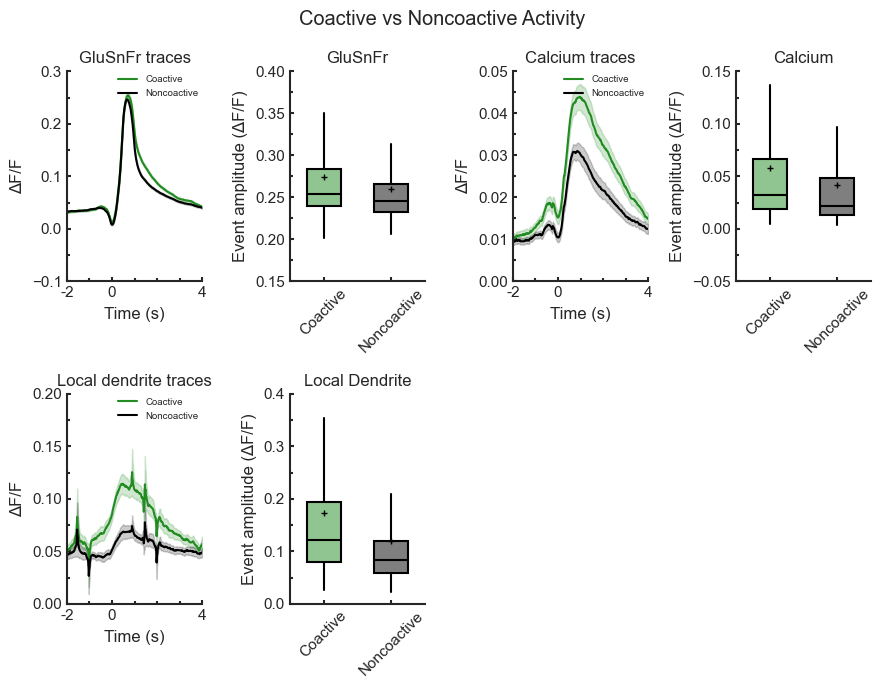

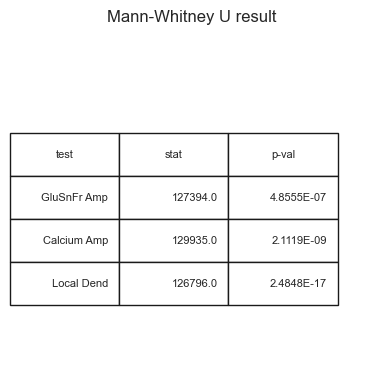

In [29]:
local_plotting.plot_coactive_vs_noncoactive_events(
    dataset=e_all_coactivity_data,
    figsize=(9, 7),
    showmeans=True,
    test_type=test_type,
    display_stats=True,
    save=False,
    save_path=figure_path
)

### Figure 2-3 Mvmt vs Non-mvmt coactivity

In [ ]:
local_plotting.plot_comparative_mvmt_coactivity(
    mvmt_dataset=e_mvmt_coactivity_data,
    nonmvmt_dataset=e_nonmvmt_coactivity_data,
    rwd_mvmts=False,
    figsize=(12,8.5),
    showmeans=False,
    mean_type=mean_type,
    err_type=err_type,
    test_type=test_type,
    display_stats=display_stats,
    save=False,
    save_path=figure_path
)

### Figures 4-7 Plasticity Coactivity Rates

In [ ]:
local_plotting.plot_plasticity_coactivity_rates(
    dataset=e_all_coactivity_data,
    mvmt_dataset=e_mvmt_coactivity_data,
    nonmvmt_dataset=e_nonmvmt_coactivity_data,
    followup_dataset=None,
    norm=False, 
    rwd_mvmt=False,
    exclude=exclude,
    threshold=threshold,
    figsize=(11, 14),
    showmeans=False,
    mean_type=mean_type,
    err_type=err_type,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path,
)

### Figures 8-9 Coactive event properties

In [ ]:
local_plotting.plot_coactive_event_properties(
    dataset=e_all_coactivity_data,
    mvmt_dataset=e_mvmt_coactivity_data,
    nonmvmt_dataset=e_nonmvmt_coactivity_data,
    followup_dataset=None,
    rwd_mvmt=False,
    exclude=exclude,
    threshold=threshold,
    figsize=(8,15),
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path,
)

### Figure 10 Nearby spine properties

In [ ]:
local_plotting.plot_nearby_spine_properties(
    dataset=e_all_coactivity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(14,22),
    mean_type=mean_type,
    err_type=err_type,
    showmeans=False,
    hist_bins=30,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path
)

### Figure 11-13 Nearby Spine Coactivity

In [ ]:
## Select what type of movement period you wish to display
local_plotting.plot_nearby_spine_coactivity(
    e_all_coactivity_data,
    followup_dataset=None,
    mvmt_type="All periods",
    exclude=exclude,
    threshold=threshold,
    figsize=(12,6),
    hist_bins=30,
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path
)

### Figure 14 Nearby Spine Movement Encoding

In [ ]:
local_plotting.plot_nearby_spine_movement_encoding(
    e_all_coactivity_data,
    followup_dataset=None,
    exclude=exclude,
    figsize=(10,6),
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=False, 
    save=False,
    save_path=figure_path,
)

### Figure 15 Local Coactivity Movement Encoding

In [ ]:
local_plotting.plot_local_movement_encoding(
    e_all_coactivity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(10,8),
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path,
)

### Figure 16-17 Local Dendritic Activity

In [ ]:
local_plotting.plot_local_dendrite_activity(
    e_all_coactivity_data,
    mvmt_coactivity_data,
    nonmvmt_coactivity_data,
    followup_dataset=None,
    rwd_mvmt=False,
    exclude=exclude,
    threshold=threshold,
    figsize=(12,8),
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path
)

## Global Dendritic Coactivity

### Load Datasets

#### Early

In [3]:
## Entire session
e_all_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)
## Mvmt periods only
e_mvmt_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="movement",
    partner=None,
)
## Nonmvmt periods only
e_nonmvmt_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="nonmovement",
    partner=None,
)


#### Middle

In [ ]:
## Entire session
m_all_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Middle",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)
## Mvmt periods only
m_mvmt_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Middle",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="movement",
    partner=None,
)
## Nonmvmt periods only
m_nonmvmt_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Middle",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="nonmovement",
    partner=None,
)


#### Late

In [ ]:
## Entire session
l_all_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Late",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)
## Mvmt periods only
l_mvmt_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Late",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="movement",
    partner=None,
)
## Nonmvmt periods only
l_nonmvmt_global_data = s_utils.load_analyzed_datasets(
    type="Global",
    grouped=True,
    session="Late",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="nonmovement",
    partner=None,
)


#### Grouped Across Days

In [ ]:
grouped_all_global_data = Grouped_Dendritic_Coactivity_Data([e_all_global_data, m_all_global_data, l_all_global_data])
grouped_mvmt_global_data = Grouped_Dendritic_Coactivity_Data([e_mvmt_global_data, m_mvmt_global_data, l_mvmt_global_data])
grouped_nonmvmt_global_data = Grouped_Dendritic_Coactivity_Data([e_nonmvmt_global_data, m_nonmvmt_global_data, l_nonmvmt_global_data])

### Figure 1 With local vs without local coactivity

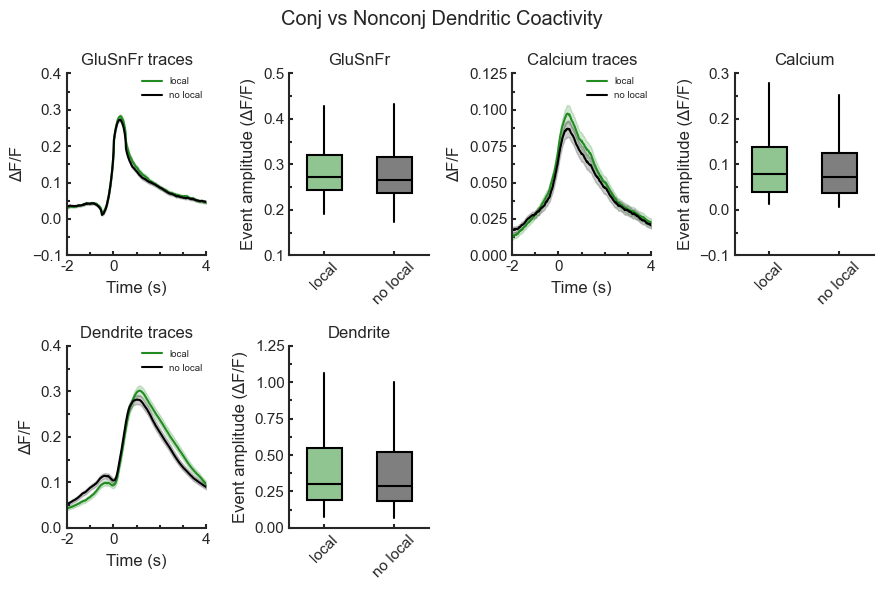

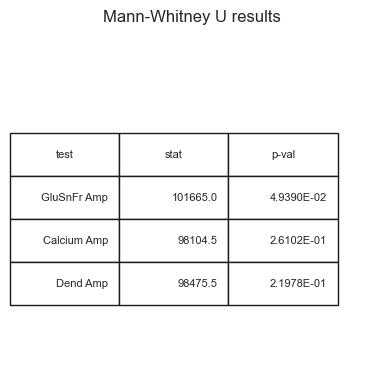

In [7]:
global_plotting.plot_conj_vs_nonconj_events(
    dataset=e_all_global_data,
    figsize=(9,6),
    showmeans=False,
    test_type=test_type,
    display_stats=display_stats,
    save=False,
    save_path=figure_path
)

### Figure 2-4 Mvmt vs Nonmvmt coactivity

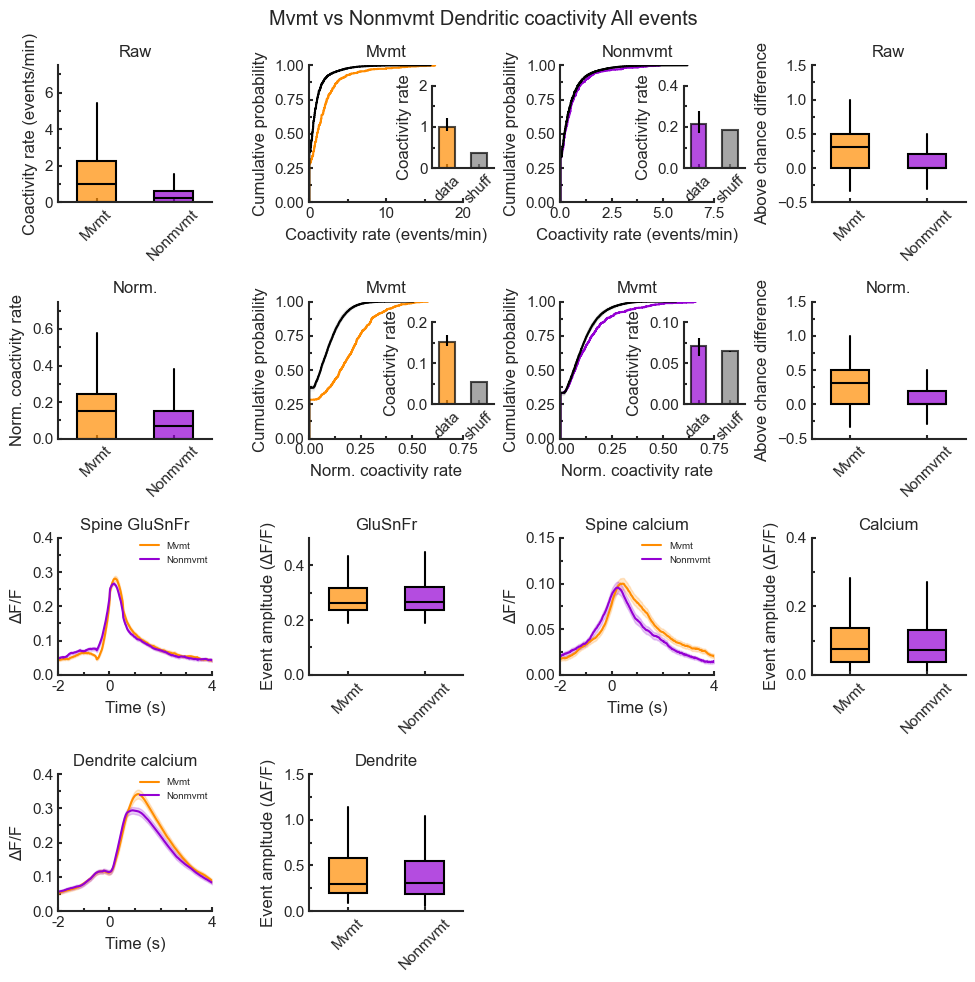

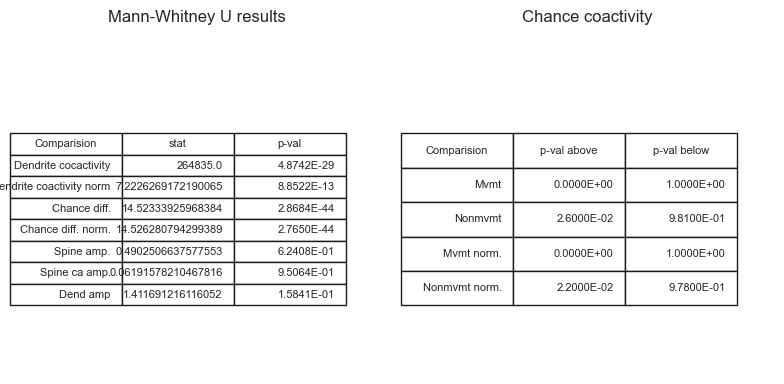

In [9]:
global_plotting.plot_comparative_mvmt_coactivity(
    mvmt_dataset=e_mvmt_global_data,
    nonmvmt_dataset=e_nonmvmt_global_data,
    coactivity_type="All",
    figsize=(10,10),
    showmeans=False,
    mean_type=mean_type,
    err_type=err_type,
    test_type=test_type,
    display_stats=display_stats,
    save=False,
    save_path=figure_path
)

### Figure 5-10 Plasticity Coactivity Rates

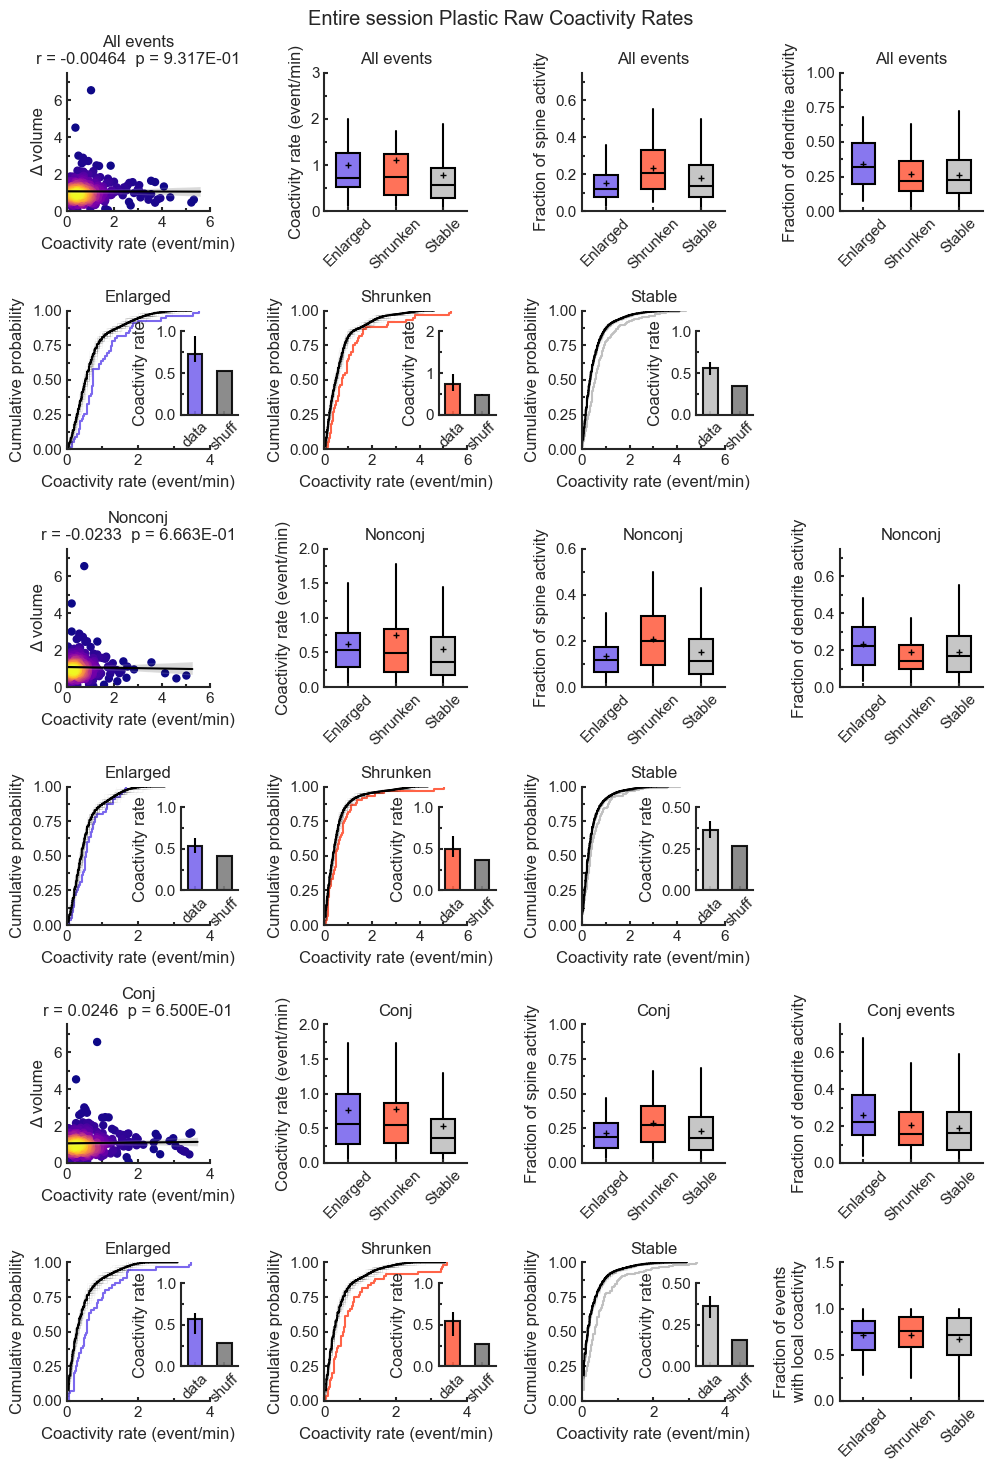

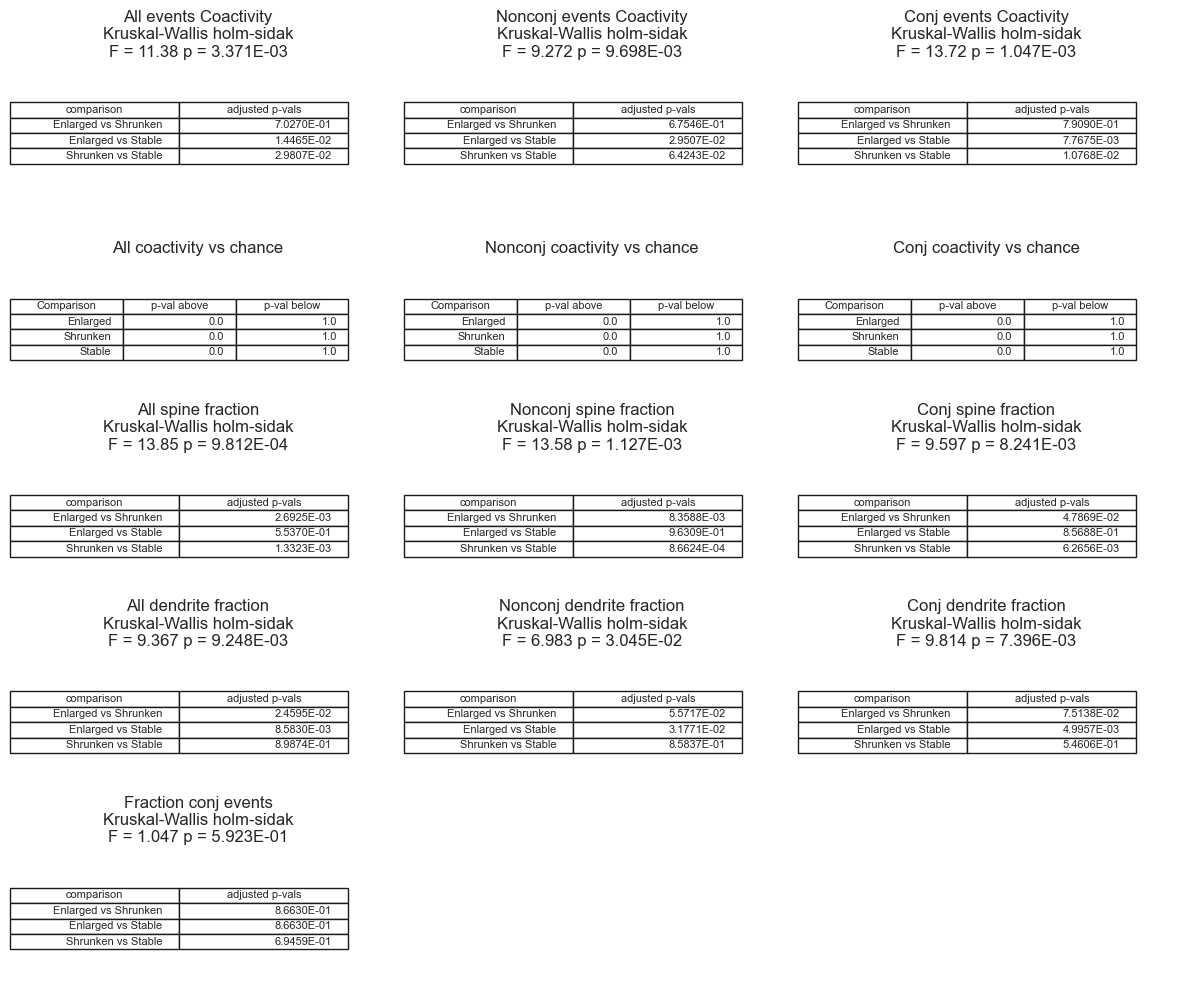

In [10]:
global_plotting.plot_plasticity_coactivity_rates(
    dataset=e_all_global_data,
    followup_dataset=None,
    period="All periods",
    norm=False,
    exclude="Shaft Spine",
    threshold=threshold,
    figsize=(10,15),
    showmeans=True,
    mean_type=mean_type,
    err_type=err_type,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=figure_path
)

### Figure 11-18 Coactivity Event Properties

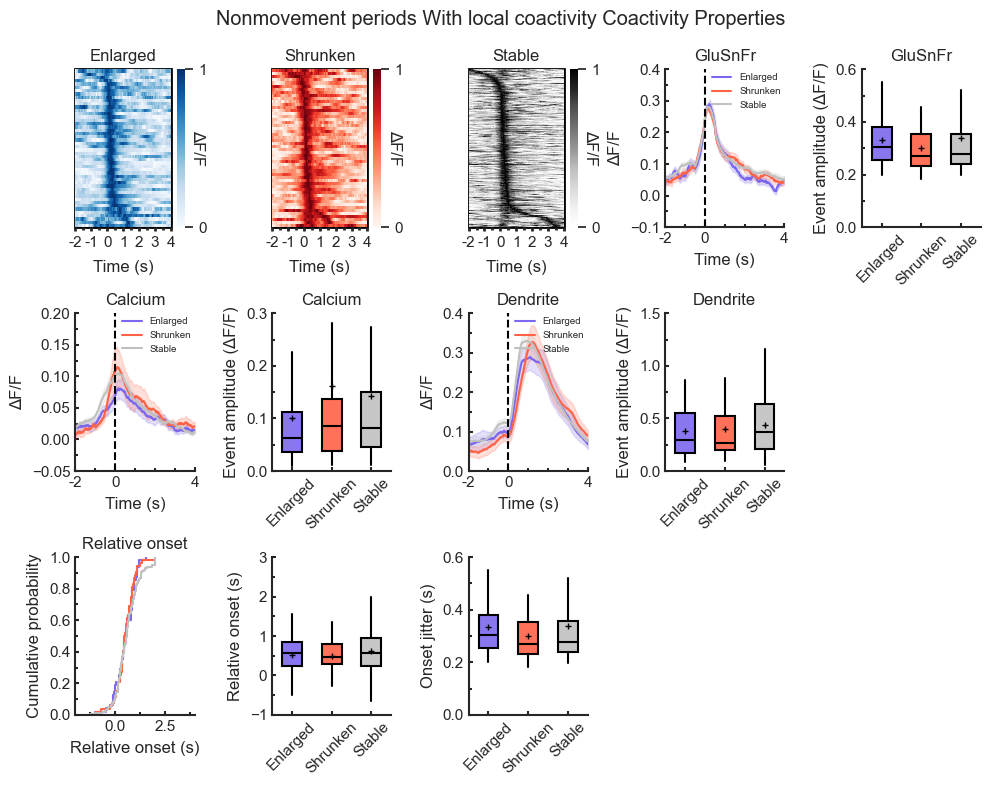

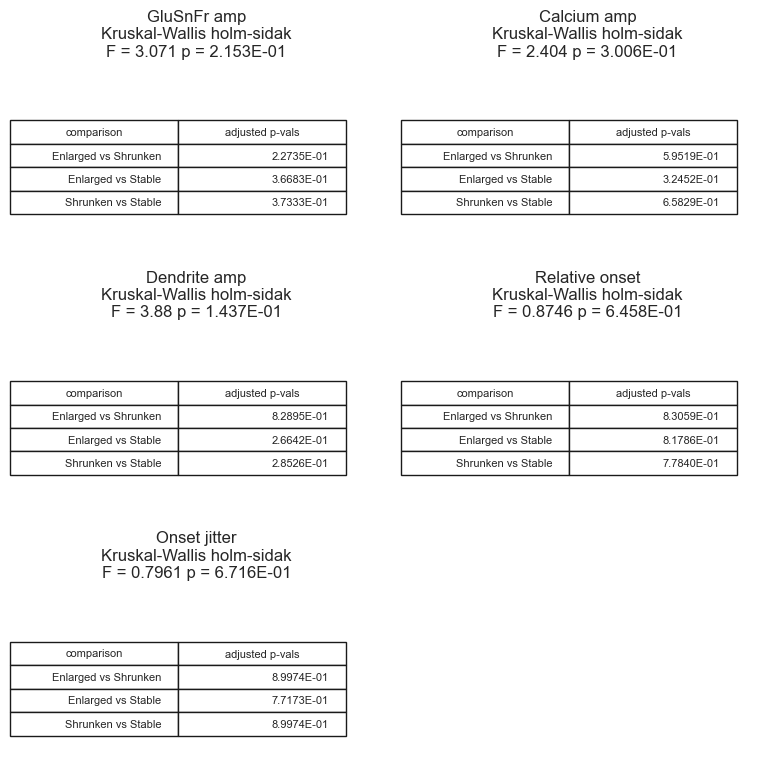

In [25]:
global_plotting.plot_coactive_event_properties(
    dataset=e_nonmvmt_global_data,
    event_type="conj",
    period="nonmovement",
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(10,8),
    showmeans=True,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    vol_norm=vol_norm,
    save=False,
    save_path=None
)